# Setup

In [2]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/My Drive/580Project/continuous"

Mounted at /content/drive
/content/drive/My Drive/580Project/continuous


In [3]:
! pip3 install qpsolvers[open_source_solvers]
! pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.9/959.9 kB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.8/452.8 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.7 MB/s eta 0:00:00


In [4]:
import torch
import numpy as np
import pandas as pd
import qpsolvers
from qpsolvers import solve_qp
from scipy.optimize import linprog, lsq_linear, minimize, LinearConstraint
import cvxopt as cvx
from sklearn.metrics import r2_score as r2_score_np
from torcheval.metrics.functional import r2_score
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from scipy.stats import norm, linregress
import pickle

# Data

In [5]:
df = pd.read_csv("../data/student/student-mat.csv", sep=';')

In [6]:
df_encoded = pd.get_dummies(df, columns=["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian",
                                         "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"], drop_first=True)
df_encoded.drop(["G1", "G2"], inplace=True, axis=1)

In [7]:
features = df_encoded.drop(["G3"], axis=1)
target = df_encoded["G3"]
X = features.values
X = X - X.mean(axis=0)
X = X/X.std(axis=0)
Y = target.values
Y = Y - Y.mean()

In [8]:
m = X.shape[1]
n = X.shape[0]
k = 10
l = 40

In [123]:
# IF TENSOR
X = torch.tensor(X)
Y = torch.tensor(Y)

# Utilities

In [9]:
def project_onto_simplex(v, select, total, solver="cvxopt"):
    P = 2*np.eye(total)
    q = -2*v.astype(np.double)
    A = np.ones((1, total))
    b = np.array([select]).astype(np.double)
    lb = np.zeros(total)
    ub = np.ones(total)
    proj = solve_qp(P, q, A=A, b=b, lb=lb, ub=ub, solver=solver)
    return proj

def frank_wolfe(gradV, select, total):
    c = gradV
    A_eq = np.ones((1, total))
    b_eq = np.array([select])
    bounds = (0, 1)
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
    return res.x

def prox_conj_grad_old(s, select):
    left = 0
    right = select
    ord = np.argsort(s)
    rord = np.argsort(ord)
    exps = np.exp(s[ord])
    smallest = select
    largest = 0
    while right - left > 1:
        curr = (left + right)//2
        val = np.sum(exps[:-curr])/exps[-curr - 1]
        if val >= select - curr:
            smallest = min(smallest, curr)
            largest = max(largest, curr)
            right = curr
        else:
            left = curr

    smallest = min(smallest, left)
    largest = max(largest, left)
    best = -select*np.sum(np.abs(s)) - select*np.log(s.size/select) - 1
    best_x = -1
    if smallest == 0:
        curr_sum = np.sum(exps)/exps[-1]
        temp = (select)/curr_sum * exps/exps[-1]
        temp = temp[rord]
        temp_score = np.einsum('n,n->', temp, s) - prox(temp, select)
        if temp_score > best and not np.any(np.isnan(temp)) and np.max(temp) <= 1:
            best = temp_score
            best_x = 0
    smallest = max(1, smallest)

    for x in range(smallest, largest+1):
        curr_sum = np.sum(exps[:-x])/exps[-x - 1]
        temp = (select - x)/curr_sum * exps[:-x]/exps[-x - 1]
        if np.any(np.isnan(temp)) or np.max(temp) > 1:
            continue
        temp = np.concatenate((temp, np.ones(x)))[rord]
        temp_score = np.einsum('n,n->', temp, s) - prox(temp, select)
        if temp_score > best:
            best = temp_score
            best_x = x

    if best_x == -1:
        final = np.concatenate((np.zeros(s.size - select), np.ones(select)))[rord]
    elif best_x == 0:
        curr_sum = np.sum(exps)/exps[-1]
        final = (select)/curr_sum * exps/exps[-1]
    else:
        curr_sum = np.sum(exps[:-best_x])/exps[-best_x - 1]
        final = (select - best_x)/curr_sum * exps[:-best_x]/exps[-best_x - 1]
        final = np.concatenate((final, np.ones(best_x)))
    return final[rord]

def prox_conj_grad(s, select):
    # res = minimize(lambda argpot: -prox_conj_opt(argpot, s, select),
    #                x0 = np.full(s.shape, select/s.size),
    #                jac=lambda argpot: -prox_conj_opt_grad(argpot, s),
    #                hess=-prox_conj_opt_hess)
    old = prox_conj_grad_old(s, select)
    return old

    try:
        res = minimize(lambda argpot: -prox_conj_opt(argpot, s, select),
                   x0 = np.full(s.shape, select/s.size), method='trust-constr',
                   constraints = [LinearConstraint(np.ones((1, s.size)), select, select)])
        new = res.x
        if np.linalg.norm(new - old) >= 1e-2:
            print(old)
            print(new)
            print("prox conj grad don't match")
        return res.x
    except:
        return old

def prox_conj_opt(argpot, s, select):
    return np.einsum('n,n->', s, argpot) - prox(argpot, select)

def prox_conj_opt_grad(argpot, s):
    return s - prox_grad(argpot)

def prox_conj_opt_hess(argpot):
    return np.diag(-1/argpot)

def prox_conj(s, select):
    argmax = prox_conj_grad(s, select)
    return prox_conj_opt(argmax, s, select)

def prox_grad(x):
    return np.log(x) + 1

def prox(x, select):
    return np.einsum('n,n->', x, np.log(x)) + select*np.log(x.size/select)

np.seterr(divide='ignore', invalid='ignore', over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [10]:
def sample_bernoulli(k, p):
    n = p.size
    sample = np.zeros(n, dtype=int)
    remaining_probabilities = p

    for _ in range(k):
        normalized_probabilities = remaining_probabilities / sum(remaining_probabilities)
        selected_index = np.random.choice(n, p=normalized_probabilities)
        sample[selected_index] = 1
        remaining_probabilities[selected_index] = 0

    return sample

# Absurd ideas of inverting random matrix

In [ ]:
class ContSolve(torch.nn.Module):
    def __init__(self, X, Y, k, l, device):
        super(ContSolve, self).__init__()
        self.X = X.to(torch.device(device))
        self.Y = Y.to(torch.device(device))
        for tensor in [self.X, self.Y]:
            tensor.requires_grad = False
        self.m = self.X.shape[1]
        self.n = self.X.shape[0]
        self.k = k
        self.l = l
        self.device = torch.device(device)
        self.ps = torch.nn.Parameter(torch.full((self.m,), self.k/self.m).to(self.device), requires_grad=True)
        self.qs = torch.nn.Parameter(torch.full((self.n,), self.l/self.n).to(self.device), requires_grad=True)

    def forward(self):
        scaled_X = torch.einsum('n,nm->nm',self.qs,self.X)
        scaled_X = torch.einsum('nm,m->nm',scaled_X,self.ps)
        scaled_Y = torch.einsum('n,n->n',self.Y,self.qs)
        tilde_M = torch.einsum('mn,np->mp',scaled_X.T,scaled_X)
        tilde_M_inv = torch.linalg.inv(tilde_M)
        tilde_M_inv_Xt = torch.einsum('mn,np->mp',tilde_M_inv,scaled_X.T)
        beta = torch.einsum('mn,n->m',tilde_M_inv_Xt,scaled_Y)
        resid = scaled_Y - torch.einsum('nm,m->n',scaled_X,beta)
        r2 = 1 - torch.einsum('n,n->',resid,resid)/torch.einsum('n,n->',scaled_Y,scaled_Y)
        return r2

In [ ]:
device = "cuda"
cs = ContSolve(X, Y, k, l, device)
learning_rate = 10
for epoch in range(1, 51):
    r2 = cs()
    print(r2)
    loss = r2
    loss.backward()
    with torch.no_grad():
        cs.qs -= learning_rate * cs.qs.grad
        cs.ps += learning_rate * cs.ps.grad
    proj = project_onto_simplex(cs.qs.detach().cpu().numpy(), l, n)
    cs.qs.data = torch.Tensor(proj).to(device)
    proj2 = project_onto_simplex(cs.ps.detach().cpu().numpy(), k, m)
    cs.ps.data = torch.Tensor(proj2).to(device)
    cs.qs.grad.zero_()
    cs.ps.grad.zero_()

In [ ]:
cs = ContSolve(X, Y, k, l, device)
cs.qs.requires_grad = True
cs.ps.requires_grad = True
for epoch in range(1, 51):
    t_k = 2/(epoch+2)
    r2 = cs()
    print(r2)
    loss = r2
    loss.backward()
    with torch.no_grad():
        y = frank_wolfe(cs.qs.grad.detach().cpu().numpy(), l, n)
        cs.qs.data = (1-t_k) * cs.qs.data + t_k * torch.Tensor(y).to(device)
        cs.qs.grad.zero_()
        y2 = frank_wolfe(-cs.ps.grad.detach().cpu().numpy(), k, m)
        cs.ps.data = (1-t_k) * cs.ps.data + t_k * torch.Tensor(y2).to(device)
        cs.ps.grad.zero_()

# Less absurd best-response algorithm

In [ ]:
class ContSolve2(torch.nn.Module):
    def __init__(self, X, Y, k, l, device, samples):
        super(ContSolve2, self).__init__()
        self.X = X.to(torch.device(device))
        self.Y = Y.to(torch.device(device))
        for tensor in [self.X, self.Y]:
            tensor.requires_grad = False
        self.m = self.X.shape[1]
        self.n = self.X.shape[0]
        self.k = k
        self.l = l
        self.device = torch.device(device)
        self.ps = torch.nn.Parameter(torch.full((self.m,), self.k/self.m).to(self.device), requires_grad=False)
        self.qs = torch.nn.Parameter(torch.full((self.n,), self.l/self.n).to(self.device), requires_grad=False)
        self.samples = samples

    def forward(self):
        m_include = torch.zeros((self.samples, self.m), dtype=torch.bool)
        n_include = torch.zeros((self.samples, self.n), dtype=torch.bool)
        res = torch.zeros(self.samples)

        for i in range(self.samples):
            m_include[i] = torch.Tensor(sample_bernoulli(self.k, self.ps))
            n_include[i] = torch.Tensor(sample_bernoulli(self.l, self.qs))
#             torch.bernoulli(self.ps, out=m_include[i])
#             torch.bernoulli(self.qs, out=n_include[i])
            if torch.sum(m_include[i]) == 0 or torch.sum(n_include[i]) == 0:
                res[i] = 0
                continue
            curr_X = self.X[n_include[i]][:, m_include[i]]
            curr_Y = self.Y[n_include[i]]
            beta = torch.linalg.lstsq(curr_X, curr_Y).solution
            pred = torch.einsum('nm,m->n',curr_X,beta)
            r2 = r2_score(pred, curr_Y)
            res[i] = 1 - (1 - r2)*torch.sum(n_include[i])/(
                torch.sum(n_include[i]) - torch.sum(m_include[i]) - 1)

        m_include = m_include.type(torch.float)
        m_sum = torch.einsum('km->m',m_include)
        m_update = torch.zeros(self.m)
        m_valid = (m_sum > 0) & (m_sum < self.samples)
        m_pos_res = torch.einsum('k,km->m',res,m_include[:,m_valid])/m_sum[m_valid]
        m_neg_res = (torch.sum(res) - m_pos_res)/(self.samples - m_sum)[m_valid]
        m_update[m_valid] = m_pos_res - m_neg_res

        n_include = n_include.type(torch.float)
        n_sum = torch.einsum('kn->n',n_include)
        n_update = torch.zeros(self.n)
        n_valid = (n_sum > 0) & (n_sum < self.samples)
        n_pos_res = torch.einsum('k,km->m',res,n_include[:,n_valid])/n_sum[n_valid]
        n_neg_res = (torch.sum(res) - n_pos_res)/(self.samples - n_sum)[n_valid]
        n_update[n_valid] = n_pos_res - n_neg_res

        return res, m_update, n_update

In [ ]:
rows, cols = X.shape
probs = [0.06, 0.12, 0.25, 0.5]
device = "cpu"
samples = 50
allqs = []
allps = []
for p in probs:
    for q in probs:
        l = int(q*n)
        k = int(p*m)
        print(l/n)
        print(k/m)
        cs = ContSolve2(X, Y, k, l, device, samples)
        prevq = cs.qs.data
        prevp = cs.ps.data
        epoch = 1
        threshold = 1e-5
        threshold2 = 1e-6
        totalp = []
        totalq = []
        while epoch <= 2 or np.linalg.norm(totalq[-1] - totalq[-2]) > threshold or np.linalg.norm(totalp[-1] - totalp[-2]) > threshold2:
            prevq = cs.qs.data
            prevp = cs.ps.data
            totalq.append(prevq.cpu().numpy().copy())
            totalp.append(prevp.cpu().numpy().copy())
            res, m_update, n_update = cs()
            if epoch % 20 == 1:
                if epoch == 501:
                    break
            learning_rate = 1/np.sqrt(epoch)
            q_prob = np.power(1-prevq.cpu().numpy(), samples) + np.power(prevq.cpu().numpy(), samples)
            cs.qs.data -= learning_rate * n_update.to(device) / torch.tensor(1 - q_prob).to(device)
            proj = project_onto_simplex(cs.qs.cpu().numpy(), l, n)
            cs.qs.data = torch.clamp(torch.Tensor(proj).to(device), min=1e-6, max=1-1e-6)
            p_prob = np.power(1-prevp.cpu().numpy(), samples) + np.power(prevp.cpu().numpy(), samples)
            cs.ps.data += learning_rate * m_update.to(device) / torch.tensor(1 - p_prob).to(device)
            proj2 = project_onto_simplex(cs.ps.cpu().numpy(), k, m)
            cs.ps.data = torch.clamp(torch.Tensor(proj2).to(device), min=1e-6, max=1-1e-6)
            epoch += 1
        allqs.append(totalq)
        allps.append(totalp)

In [ ]:
with open('simplex_qs2.pkl', 'wb') as f:
    pickle.dump(allqs, f)
with open('simplex_ps2.pkl', 'wb') as f:
    pickle.dump(allps, f)

In [ ]:
rows, cols = X.shape
probs = [0.06, 0.12, 0.25, 0.5]
device = "cpu"
samples = 50
allqs2 = []
allps2 = []
for p in probs:
    for q in probs:
        l = int(q*n)
        k = int(p*m)
        print(l/n)
        print(k/m)
        cs = ContSolve2(X, Y, k, l, device, samples)
        prevq = cs.qs.data
        prevp = cs.ps.data
        epoch = 1
        threshold = 1e-5
        threshold2 = 1e-6
        totalp = []
        totalq = []
        while epoch <= 2 or np.linalg.norm(totalq[-1] - totalq[-2]) > threshold or np.linalg.norm(totalp[-1] - totalp[-2]) > threshold2:
            prevq = cs.qs.data
            prevp = cs.ps.data
            totalq.append(prevq.cpu().numpy().copy())
            totalp.append(prevp.cpu().numpy().copy())
            res, m_update, n_update = cs()
            if epoch % 20 == 1:
                if epoch == 501:
                    break
            learning_rate = 1/np.sqrt(epoch)
            q_prob = np.power(1-prevq.cpu().numpy(), samples) + np.power(prevq.cpu().numpy(), samples)
            cs.qs.data -= learning_rate * n_update.to(device) / torch.tensor(1 - q_prob).to(device)
            proj = project_onto_simplex(cs.qs.cpu().numpy(), l, n)
            cs.qs.data = torch.clamp(torch.Tensor(proj).to(device), min=1e-6, max=1-1e-6)
            p_prob = np.power(1-prevp.cpu().numpy(), samples) + np.power(prevp.cpu().numpy(), samples)
            cs.ps.data += learning_rate * m_update.to(device) / torch.tensor(1 - p_prob).to(device)
            proj2 = project_onto_simplex(cs.ps.cpu().numpy(), k, m)
            cs.ps.data = torch.clamp(torch.Tensor(proj2).to(device), min=1e-6, max=1-1e-6)
            epoch += 1
        allqs2.append(totalq)
        allps2.append(totalp)

In [ ]:
with open('simplex_qs.pkl', 'wb') as f:
    pickle.dump(allqs, f)
with open('simplex_ps.pkl', 'wb') as f:
    pickle.dump(allps, f)

In [ ]:
rows, cols = X.shape
probs = [0.06, 0.1, 0.25, 0.5]
device = "cuda"
samples = 50
allqs2 = []
allps2 = []

for p in probs:
    for q in probs:
        l = int(q*n)
        k = int(p*m)
        cs = ContSolve2(X, Y, k, l, device, samples)
        prevq = cs.qs.data
        prevp = cs.ps.data
        epoch = 1
        threshold = 1e-5
        threshold2 = 1e-6
        totalp = []
        totalq = []

        while epoch <= 2 or np.linalg.norm(totalq[-1] - totalq[-2]) > threshold or np.linalg.norm(totalp[-1] - totalp[-2]) > threshold2:
            prevq = cs.qs.data
            prevp = cs.ps.data
            totalq.append(prevq.cpu().numpy().copy())
            totalp.append(prevp.cpu().numpy().copy())
            res, m_update, n_update = cs()
            if epoch % 20 == 1:
                if epoch == 501:
                    break

            t_k = 1/np.sqrt(epoch)
            # q_prob = np.power(1-prevq.cpu().numpy(), samples) + np.power(prevq.cpu().numpy(), samples)
            # t_q_k = t_k / torch.tensor(1 - q_prob).to(device)
            # p_prob = np.power(1-prevp.cpu().numpy(), samples) + np.power(prevp.cpu().numpy(), samples)
            # t_p_k = t_k / torch.tensor(1 - p_prob).to(device)

            y = frank_wolfe(n_update.cpu().numpy(), l, n)
            cs.qs.data = (1-t_k) * cs.qs.data + t_k * torch.Tensor(y).to(device)
            y2 = frank_wolfe(-m_update.cpu().numpy(), k, m)
            cs.ps.data = (1-t_k) * cs.ps.data + t_k * torch.Tensor(y2).to(device)
            epoch += 1

        allqs2.append(prevq)
        allps2.append(prevp)

In [ ]:
with open('frank_wolfe_qs.pkl', 'wb') as f:
    pickle.dump(allqs2, f)
with open('frank_wolfe_ps.pkl', 'wb') as f:
    pickle.dump(allps2, f)

In [ ]:
with open('simplex_qs.pkl', 'rb') as f:
    allqs = pickle.load(f)
with open('simplex_ps.pkl', 'rb') as f:
    allps = pickle.load(f)

# Even less absurd nash algorithm

In [129]:
class ContSolve3(torch.nn.Module):
    def __init__(self, X, Y, k, l, samples):
        super(ContSolve3, self).__init__()
        self.X = X
        self.Y = Y
        self.m = self.X.shape[1]
        self.n = self.X.shape[0]
        self.k = k
        self.l = l
#        self.ps = np.full((self.m,), self.k/self.m)
#        self.qs = np.full((self.n,), self.l/self.n)
        self.samples = samples
        self.rng = np.random.default_rng()

    def init_sample(self, ps, qs):
        res = np.zeros(self.samples)
        m_include = self.rng.binomial(n=1, p=ps[:, None], size=(len(ps), self.samples)).T
        n_include = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), self.samples)).T
        for i in range(self.samples):
            while np.sum(m_include[i]) == 0:
                m_include[i] = self.rng.binomial(n=1, p=ps[:, None], size=(len(ps), 1))
            while np.sum(n_include[i]) == 0:
                n_include[i] = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), 1))
            curr_X = self.X[n_include[i]][:, m_include[i]]
            curr_Y = self.Y[n_include[i]]
            beta = np.linalg.lstsq(curr_X, curr_Y, rcond=None)[0]
            pred = np.einsum('nm,m->n',curr_X,beta)
            r2 = r2_score_np(curr_Y, pred)
            res[i] = 1 - (1 - r2)*np.sum(n_include[i])/(
                np.sum(n_include[i]) - np.sum(m_include[i]) - 1)

        return m_include, n_include, res

    def forward(self, ps, qs):
        # print(ps, qs)
        m_include, n_include, res = self.init_sample(ps, qs)

        m_include = m_include.astype(float)
        m_sum = np.einsum('km->m',m_include)
        m_pos_res = np.zeros(self.m)
        m_neg_res = np.zeros(self.m)
        m_update = np.zeros(self.m)
        m_pos_valid = (m_sum > 0)
        m_neg_valid = (m_sum < self.samples)
        m_pos_raw = np.einsum('k,km->m',res,m_include)
        m_pos_res_curr = m_pos_raw[m_pos_valid]/m_sum[m_pos_valid]
        m_neg_res_curr = ((np.sum(res) - m_pos_raw)[m_neg_valid]/(self.samples - m_sum)[m_neg_valid])
        m_pos_res[m_pos_valid] = m_pos_res_curr
        m_neg_res[m_neg_valid] = m_neg_res_curr

        for invalid in np.where(m_pos_valid == 0)[0]:
            temp_res = np.zeros(1)
            for i in range(temp_res.size):
                invalid_sample = self.rng.binomial(n=1, p=ps[:, None], size=(len(ps), 1)).T[0]
                invalid_sample[invalid] = 1
                n_sample = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), 1)).T[0]
                while np.sum(n_sample) == 0:
                    n_sample = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), 1)).T[0]
                curr_X = self.X[n_sample][:, invalid_sample]
                curr_Y = self.Y[n_sample]
                beta = np.linalg.lstsq(curr_X, curr_Y, rcond=None)[0]
                pred = np.einsum('nm,m->n',curr_X,beta)
                r2 = r2_score_np(curr_Y, pred)
                temp_res[i] = 1 - (1 - r2)*np.sum(n_sample)/(
                    np.sum(n_sample) - np.sum(invalid_sample) - 1)
            m_pos_res[invalid] = np.mean(temp_res)

        for invalid in np.where(m_neg_valid == 0)[0]:
            temp_res = np.zeros(1)
            for i in range(temp_res.size):
                invalid_sample = self.rng.binomial(n=1, p=ps[:, None], size=(len(ps), 1)).T[0]
                invalid_sample[invalid] = 0
                n_sample = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), 1)).T[0]
                while np.sum(n_sample) == 0:
                    n_sample = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), 1)).T[0]
                curr_X = self.X[n_sample][:, invalid_sample]
                curr_Y = self.Y[n_sample]
                beta = np.linalg.lstsq(curr_X, curr_Y, rcond=None)[0]
                pred = np.einsum('nm,m->n',curr_X,beta)
                r2 = r2_score_np(curr_Y, pred)
                temp_res[i] = 1 - (1 - r2)*np.sum(n_sample)/(
                    np.sum(n_sample) - np.sum(invalid_sample) - 1)
            m_neg_res[invalid] = np.mean(temp_res)

        m_update = m_pos_res - m_neg_res

        n_include = n_include.astype(float)
        n_sum = np.einsum('kn->n',n_include)
        n_pos_res = np.zeros(self.n)
        n_neg_res = np.zeros(self.n)
        n_update = np.zeros(self.n)
        n_pos_valid = (n_sum > 0)
        n_neg_valid = (n_sum < self.samples)
        n_pos_raw = np.einsum('k,kn->n',res,n_include)
        n_pos_res_curr = n_pos_raw[n_pos_valid]/n_sum[n_pos_valid]
        n_neg_res_curr = ((np.sum(res) - n_pos_raw)[n_neg_valid]/(self.samples - n_sum)[n_neg_valid])
        n_pos_res[n_pos_valid] = n_pos_res_curr
        n_neg_res[n_neg_valid] = n_neg_res_curr

        for invalid in np.where(n_pos_valid == 0)[0]:
            temp_res = np.zeros(1)
            for i in range(temp_res.size):
                invalid_sample = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), 1)).T[0]
                invalid_sample[invalid] = 1
                m_sample = self.rng.binomial(n=1, p=ps[:, None], size=(len(ps), 1)).T[0]
                while np.sum(m_sample) == 0:
                    m_sample = self.rng.binomial(n=1, p=ps[:, None], size=(len(ps), 1)).T[0]
                curr_X = self.X[invalid_sample][:, m_sample]
                curr_Y = self.Y[invalid_sample]
                beta = np.linalg.lstsq(curr_X, curr_Y, rcond=None)[0]
                pred = np.einsum('nm,m->n',curr_X,beta)
                r2 = r2_score_np(curr_Y, pred)
                temp_res[i] = 1 - (1 - r2)*np.sum(invalid_sample)/(
                    np.sum(invalid_sample) - np.sum(m_sample) - 1)
            n_pos_res[invalid] = np.mean(temp_res)

        for invalid in np.where(n_pos_valid == 0)[0]:
            temp_res = np.zeros(1)
            for i in range(temp_res.size):
                invalid_sample = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), 1)).T[0]
                invalid_sample[invalid] = 0
                while np.sum(invalid_sample) == 0:
                    invalid_sample = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), 1)).T[0]
                    invalid_sample[invalid] = 0
                m_sample = self.rng.binomial(n=1, p=ps[:, None], size=(len(ps), 1)).T[0]
                while np.sum(m_sample) == 0:
                    m_sample = self.rng.binomial(n=1, p=ps[:, None], size=(len(ps), 1)).T[0]
                curr_X = self.X[invalid_sample][:, m_sample]
                curr_Y = self.Y[invalid_sample]
                beta = np.linalg.lstsq(curr_X, curr_Y, rcond=None)[0]
                pred = np.einsum('nm,m->n',curr_X,beta)
                r2 = r2_score_np(curr_Y, pred)
                temp_res[i] = 1 - (1 - r2)*np.sum(invalid_sample)/(
                    np.sum(invalid_sample) - np.sum(m_sample) - 1)
            n_neg_res[invalid] = np.mean(temp_res)

        n_update = n_pos_res - n_neg_res

        return res, m_update, n_update

In [130]:
samples = 50
k = 10
l = 40
cs3 = ContSolve3(X, Y, k, l, samples)

def initial(m, n):
    mu_q, mu_p = 1, 1
    hat_q = prox_conj_grad(np.zeros(n), l)
    _, Aq, _ = cs3.forward(np.full(X.shape[1], k/X.shape[1]), hat_q)
    p_0 = prox_conj_grad(Aq/mu_p, k)
    _, _, ATp = cs3.forward(p_0, hat_q)
    q_0 = prox_conj_grad(prox_grad(hat_q) - ATp/mu_q, l)
    return (mu_q, mu_p, q_0, p_0)

def shrink1(mu_q, mu_p, tau, q, p):
    _, _, ATp = cs3.forward(p, q)
    qwed = prox_conj_grad(-ATp/mu_q, l)
    qhat = (1-tau)*q + tau*qwed
    _, Aq, _ = cs3.forward(p, qhat)
    phat = prox_conj_grad(Aq/mu_p, k)
    _, _, ATp = cs3.forward(phat, qhat)
    qtild = prox_conj_grad(prox_conj(qwed, l) - tau/((1-tau)*mu_q)*ATp, l)
    pp = (1-tau)*p + tau*phat
    qp = (1-tau)*q + tau*qtild
    mu_q = (1-tau)*mu_q
    return (mu_q, qp, pp)

def shrink2(mu_q, mu_p, tau, q, p):
    _, Aq, _ = cs3.forward(p, q)
    pwed = prox_conj_grad(Aq/mu_p, k)
    phat = (1-tau)*p + tau*pwed
    _, _, ATp = cs3.forward(phat, q)
    qhat = prox_conj_grad(-ATp/mu_q, l)
    _, Aq, _ = cs3.forward(phat, qhat)
    ptild = prox_conj_grad(prox_conj(pwed, k) - tau/((1-tau)*mu_p)*(-Aq), k)
    qp = (1-tau)*q + tau*qhat
    pp = (1-tau)*p + tau*ptild
    mu_p = (1-tau)*mu_p
    return (mu_p, pp, qp)

def egt(num_epochs = 100):
    mu_q, mu_p, q, p = initial(X.shape[1], X.shape[0])
    ps = np.zeros((num_epochs//2, p.size))
    qs = np.zeros((num_epochs//2, q.size))
    for k in range(num_epochs):
        tau = 2/(k+3)
        if k % 2 == 0:
            mu_q, q, p = shrink1(mu_q, mu_p, tau, q, p)
        else:
            mu_p, p, q = shrink2(mu_q, mu_p, tau, q, p)
            ps[k//2] = p
            qs[k//2] = q
    return ps, qs

In [ ]:
ps, qs = egt()

In [ ]:
qs[-1]

In [134]:
np.savetxt("ps.txt", ps)
np.savetxt("qs.txt", qs)

# Maybe better nash algorithm

In [35]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

2

In [11]:
class ContSolve4(torch.nn.Module):
    def __init__(self, X, Y, k, l, col_samples, row_samples, rep_method='random', rep_score='mean', ols_weight='score'):
        super(ContSolve4, self).__init__()
        self.rng = np.random.default_rng()
        self.X = X
        self.Y = Y
        self.m = self.X.shape[1]
        self.n = self.X.shape[0]
        self.k = k
        self.l = l
        self.col_samples = col_samples
        self.row_samples = row_samples

        valid_method = {'random'}
        if rep_method not in valid_method:
            raise ValueError("method not implemented")
        self.method = rep_method

        valid_score = {'mean', 'max'}
        if rep_score not in valid_score:
            raise ValueError("score not implemented")
        self.score = rep_score

        if ols_weight == 'score':
            self.weight = np.vectorize(lambda x: x)
        elif ols_weight == 'unit':
            self.weight = np.vectorize(lambda x: 1)
        else:
            raise ValueError("weight not implemented")

    def row_update(self, ps): # Ax, samples = [# random, # for representative group]
        global best_score
        global worst_score
        samples = self.row_samples
        m_include = self.rng.binomial(n=1, p=ps[:, None], size=(len(ps), samples[0])).T
        for i in range(samples[0]):
            while np.sum(m_include[i]) == 0:
                m_include[i] = self.rng.binomial(n=1, p=ps[:, None], size=(len(ps), 1))
        if self.method == 'random':
            n_include = np.zeros((samples[1], self.n))
            for i in range(samples[1]):
                n_include[i][np.random.choice(self.n, self.l, replace=False)] = 1
            rem = np.nonzero(n_include.sum(axis=0) == 0)[0]
            n_include = np.concatenate([n_include, np.zeros((rem.size, self.n))])
            for i in range(rem.size):
                choice = np.random.choice(self.n - 1, self.l, replace=False)
                upd_choice = np.concatenate([choice + choice >= rem[i], [rem[i]]])
                n_include[samples[1]+i][upd_choice] = 1
            n_include = n_include.astype(int)
        m_include = m_include.astype(bool)
        n_include = n_include.astype(bool)

        res = np.zeros(n_include.shape[0])
        for i in range(n_include.shape[0]):
            for j in range(samples[0]):
                curr_X = self.X[n_include[i]][:, m_include[j]]
                curr_Y = self.Y[n_include[i]]
                beta = np.linalg.lstsq(curr_X, curr_Y, rcond=None)[0]
                pred = np.einsum('nm,m->n',curr_X,beta)
                r2 = r2_score_np(curr_Y, pred)
                val = r2
                best_score = max(best_score, val)
                worst_score = min(worst_score, val)
                # val = 1 - (1 - r2)*np.sum(n_include[i])/(np.sum(n_include[i]) - np.sum(m_include[j]) - 1)
                if self.score == 'mean':
                    res[i] += val/samples[0]
                elif self.score == 'max':
                    res[i] = max(res[i], val)
        res = (res - worst_score)/best_score
        res_scale = np.einsum('n,n->n',res,n_include.sum(axis=1))
        w = self.weight(res) # res # np.ones_like(res)
        Aw = np.einsum('sn,s -> sn',n_include,np.sqrt(w))
        Bw = np.einsum('n,n->n',res_scale,np.sqrt(w))
        ATp = lsq_linear(Aw, Bw, bounds=(0, 1)).x
        # ATp = np.max(n_include * res[:, None], axis=0)
        return ATp

    def col_update(self, qs): # ATy, samples = [# random, # for representative group]
        global best_score
        global worst_score
        samples = self.col_samples
        n_include = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), samples[0])).T
        for j in range(samples[0]):
            while np.sum(n_include[j]) == 0:
                n_include[j] = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), 1))
        if self.method == 'random':
            m_include = np.zeros((samples[1], self.m))
            for i in range(samples[1]):
                m_include[i][np.random.choice(self.m, self.k, replace=False)] = 1
            rem = np.nonzero(m_include.sum(axis=0) == 0)[0]
            m_include = np.concatenate([m_include, np.zeros((rem.size, self.m))])
            for i in range(rem.size):
                choice = np.random.choice(self.m - 1, self.k, replace=False)
                upd_choice = np.concatenate([choice + choice >= rem[i], [rem[i]]])
                m_include[samples[1]+i][upd_choice] = 1
        n_include = n_include.astype(bool)
        m_include = m_include.astype(bool)

        res = np.zeros(m_include.shape[0])
        for i in range(m_include.shape[0]):
            for j in range(samples[0]):
                curr_X = self.X[n_include[j]][:, m_include[i]]
                curr_Y = self.Y[n_include[j]]
                beta = np.linalg.lstsq(curr_X, curr_Y, rcond=None)[0]
                pred = np.einsum('nm,m->n',curr_X,beta)
                r2 = r2_score_np(curr_Y, pred)
                val = r2
                best_score = max(best_score, val)
                worst_score = min(worst_score, val)
                # val = 1 - (1 - r2)*np.sum(n_include[j])/(np.sum(n_include[j]) - np.sum(m_include[i]) - 1)
                if self.score == 'mean':
                    res[i] += val/samples[0]
                elif self.score == 'max':
                    res[i] = max(res[i], val)
        res = (res - worst_score)/best_score
        res_scale = np.einsum('n,n->n',res,m_include.sum(axis=1))
        w = self.weight(res) # res # np.ones_like(res)
        Aw = np.einsum('sm,s -> sm',m_include,np.sqrt(w))
        Bw = np.einsum('n,n->n',res_scale,np.sqrt(w))
        Aq = lsq_linear(Aw, Bw, bounds=(0, 1)).x
        # Aq = np.max(m_include * res[:, None], axis=0)
        return Aq


    # unfinished
    def parallel_update(self, qs):
        global best_score
        global worst_score
        samples = self.col_samples
        n_include = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), samples[0])).T
        for j in range(samples[0]):
            while np.sum(n_include[j]) == 0:
                n_include[j] = self.rng.binomial(n=1, p=qs[:, None], size=(len(qs), 1))

In [18]:
k = 10
l = 40
col_samples = [int(np.log(1/3)/np.log(1-l/X.shape[0])), 2*int(np.log(1/X.shape[1])/np.log(1-k/X.shape[1]))]
row_samples = [int(np.log(1/3)/np.log(1-k/X.shape[1])), 2*int(np.log(1/X.shape[0])/np.log(1-l/X.shape[0]))]
cs4 = ContSolve4(X, Y, k, l, col_samples, row_samples)

def initial(cs4, m, n, coef):
    mu_q, mu_p = 1, 1
    hat_q = prox_conj_grad(np.zeros(n), l)
    Aq = cs4.col_update(hat_q)*coef
    p_0 = prox_conj_grad(Aq/mu_p, k)
    ATp = cs4.row_update(p_0)*coef
    q_0 = prox_conj_grad(prox_grad(hat_q) - ATp/mu_q, l)
    return (mu_q, mu_p, q_0, p_0)

def shrink1(cs4, mu_q, mu_p, tau, q, p, coef):
    ATp = cs4.row_update(p)*coef
    qwed = prox_conj_grad(-ATp/mu_q, l)
    qhat = (1-tau)*q + tau*qwed
    Aq = cs4.col_update(qhat)*coef
    phat = prox_conj_grad(Aq/mu_p, k)
    ATp = cs4.row_update(phat)*coef
    qtild = prox_conj_grad(prox_conj(qwed, l) - tau/((1-tau)*mu_q)*ATp, l)
    pp = (1-tau)*p + tau*phat
    qp = (1-tau)*q + tau*qtild
    mu_q = (1-tau)*mu_q
    return (mu_q, qp, pp)

def shrink2(cs4, mu_q, mu_p, tau, q, p, coef):
    Aq = cs4.col_update(q)*coef
    pwed = prox_conj_grad(Aq/mu_p, k)
    phat = (1-tau)*p + tau*pwed
    ATp = cs4.row_update(phat)*coef
    qhat = prox_conj_grad(-ATp/mu_q, l)
    Aq = cs4.col_update(qhat)*coef
    ptild = prox_conj_grad(prox_conj(pwed, k) - tau/((1-tau)*mu_p)*(-Aq), k)
    qp = (1-tau)*q + tau*qhat
    pp = (1-tau)*p + tau*ptild
    mu_p = (1-tau)*mu_p
    return (mu_p, pp, qp)

def egt_mod(num_epochs = 500, coef = 1, rep_score = 'mean', ols_weight = 'score'):
    cs4.rep_score=rep_score
    cs4.ols_weight=ols_weight
    mu_q, mu_p, q, p = initial(cs4, X.shape[1], X.shape[0], coef)
    ps = np.zeros((num_epochs//2, p.size))
    qs = np.zeros((num_epochs//2, q.size))
    for k in range(num_epochs):
        tau = 2/(k+3)
        if k % 2 == 0:
            mu_q, q, p = shrink1(cs4, mu_q, mu_p, tau, q, p, coef)
        else:
            mu_p, p, q = shrink2(cs4, mu_q, mu_p, tau, q, p, coef)
            ps[k//2] = p
            qs[k//2] = q
    return ps, qs

In [ ]:
best_score = 0
worst_score = 1
ps, qs = egt_mod()

In [33]:
best_score = 0
worst_score = 1
ps2, qs2 = egt_mod()

In [34]:
allp, allq, allp2, allq2 = ps, qs, ps2, qs2

In [35]:
include = (np.argsort(-allp, axis=1) <= k).astype(int)
np.sum(np.abs(include[1:] - include[:-1]), axis=1)

array([12, 14, 12, 18, 18, 16, 14, 20, 14, 12, 14, 16, 14, 12, 12, 10,  8,
       10, 12, 10, 12, 14, 12, 12, 10, 14, 12, 14,  8, 10,  8, 12, 10, 14,
       16, 10, 10, 10, 16, 12, 10, 14, 14, 16, 10, 14, 16, 12,  8,  8,  8,
        8,  8,  8,  8,  8,  8, 14, 12, 10,  8, 10,  6, 12,  6, 10, 12, 10,
        6, 12, 10,  8,  8, 10, 12,  8,  6,  6,  8, 10,  8,  4,  8,  8,  4,
        6,  4,  4,  8,  4,  6,  4,  4,  4,  4,  0,  2,  2,  2,  0,  2,  2,
        2,  2,  6,  6,  4,  4,  2,  6, 12, 10,  6,  4,  0,  2,  4,  2,  8,
        4,  4,  0,  0,  2,  4,  6,  0,  2,  2, 10,  4,  4,  8,  4,  2,  2,
        6,  0,  2,  2,  6,  6,  4,  8,  4,  0,  2,  0,  4,  6,  4,  4,  2,
        2,  0,  4,  4,  4,  0,  8, 10,  2,  4,  8, 10,  2,  0,  4,  2,  4,
        2,  2,  2,  2,  0,  6,  4,  0,  6,  6,  4,  6,  0,  4,  6,  4,  0,
        4,  2,  4,  6,  0,  4,  0,  4,  0,  4,  0,  4,  6,  2,  2,  0,  8,
        2,  4,  8,  2,  6,  2,  6,  6,  2,  2,  2, 10,  4,  2,  8,  2,  4,
        2, 10,  2,  0,  6

In [36]:
include = (np.argsort(-allp2, axis=1) <= k).astype(int)
np.sum(np.abs(include[1:] - include[:-1]), axis=1)

array([14, 18, 14, 16, 18, 14, 18, 16, 14, 16, 14, 12, 14, 14, 10, 14, 16,
       10, 14, 12, 16, 12, 16, 18, 12, 14, 14, 14, 12, 10, 14, 12, 12, 10,
       12, 14, 10, 12, 10, 10, 10, 12,  8,  8, 10, 14, 12, 12, 14, 14,  8,
       14, 14, 18, 10,  8, 12, 12, 14,  8, 12, 12,  6, 14, 12, 12, 10,  8,
       12, 12, 12, 16, 10, 12, 14, 14, 14, 12, 16, 10, 14, 10, 12,  4, 12,
       10,  6, 14, 10, 10, 12, 12, 10, 10, 12, 14, 10, 10,  4,  8, 12, 12,
       12, 14, 10,  4,  6, 10, 10,  8,  6, 12,  8, 12, 10, 12, 14, 14,  6,
        8,  8,  8, 10, 12, 10, 12, 12,  8, 10,  8,  8, 10,  4,  8,  4, 12,
       10, 10,  6, 14,  6, 10,  4, 10,  8, 10,  6, 10,  6,  6,  6, 10,  6,
        6,  4,  8,  4,  4,  8,  8,  6,  4,  6,  8,  6,  4,  6, 12, 10,  4,
        8,  0,  4,  6,  6,  6,  4,  2,  6,  6,  4,  6,  2, 10,  8, 10, 10,
       10, 10,  6,  8,  6,  4,  6, 10,  4,  4,  8,  6,  4,  4,  6,  6,  4,
        6, 10,  4, 10,  8,  4,  4,  6,  8,  6,  4,  4,  8,  6,  2,  8,  8,
        8,  6, 10,  4, 12

In [13]:
best_score = 0
worst_score = 1
ps3, qs3 = egt_mod(coef = 2, ols_weight = 'unit')
best_score = 0
worst_score = 1
ps4, qs4 = egt_mod(coef = 2, ols_weight='score')
allp3, allq3, allp4, allq4 = ps3, qs3, ps4, qs4

In [33]:
best_score = 0
worst_score = 1
ps5, qs5 = egt_mod(num_epochs = 100, coef = 5, ols_weight = 'unit')
best_score = 0
worst_score = 1
ps6, qs6 = egt_mod(num_epochs = 100, coef = 5, ols_weight='score')
allp5, allq5, allp6, allq6 = ps5, qs5, ps6, qs6

# Epsilon Nash Heuristic

In [27]:
def find_best_mod(x, y, ps, qs, k, l, verify=1, num_samples=100, numpy_type=False):

    # TODO: handle mixed probabilities better
    largest_col_indices = np.argsort(-ps)[:k]
    largest_row_indices = np.argsort(-qs)[:l]
    final_x = x[largest_row_indices][:, largest_col_indices]
    if not numpy_type:
        final_x = final_x.numpy()
    final_y = y[largest_row_indices]
    if not numpy_type:
        final_y.numpy()
    reg = LinearRegression().fit(final_x, final_y)
    pred = reg.predict(final_x)
    final_r2 = r2_score_np(final_y, pred)

    if verify == 1:
        best_r2 = 1
        largest_indices = np.argsort(-ps)[:k]
        curr_x = x[:, largest_indices]
        for i in range(num_samples):
            random_indices = np.random.choice(qs.size, size=l, replace=False)
            temp_x = curr_x[random_indices]
            temp_y = y[random_indices]
            reg = LinearRegression().fit(temp_x, temp_y)
            pred = reg.predict(temp_x)
            r2 = r2_score_np(temp_y, pred)
            if best_r2 > r2:
                best_r2 = r2
        return final_r2 - best_r2

    elif verify == 2:
        best_r2 = 0
        largest_indices = np.argsort(-qs)[:l]
        curr_x = x[largest_indices, :]
        curr_y = y[largest_indices]
        for i in range(num_samples):
            random_indices = np.random.choice(ps.size, size=k, replace=False)
            temp_x = curr_x[:, random_indices]
            reg = LinearRegression().fit(temp_x, curr_y)
            pred = reg.predict(temp_x)
            r2 = r2_score_np(curr_y, pred)
            if best_r2 < r2:
                best_r2 = r2
        return best_r2 - final_r2

def row_col_devs(allp, allq, checks, k = None, l = None, numpy_type=False):
    if k is None:
        k = round(np.sum(allp[-1]))
    if l is None:
        l = round(np.sum(allq[-1]))
    row_devs = []
    col_devs = []

    for j in np.linspace(0, len(allp)-1, checks):
        currps = allp[int(j)]
        currqs = allq[int(j)]
        row_dev = find_best_mod(X, Y, currps, currqs, k, l, verify=1, numpy_type=numpy_type)
        col_dev = find_best_mod(X, Y, currps, currqs, k, l, verify=2, numpy_type=numpy_type)
        row_devs.append(row_dev)
        col_devs.append(col_dev)

    return row_devs, col_devs

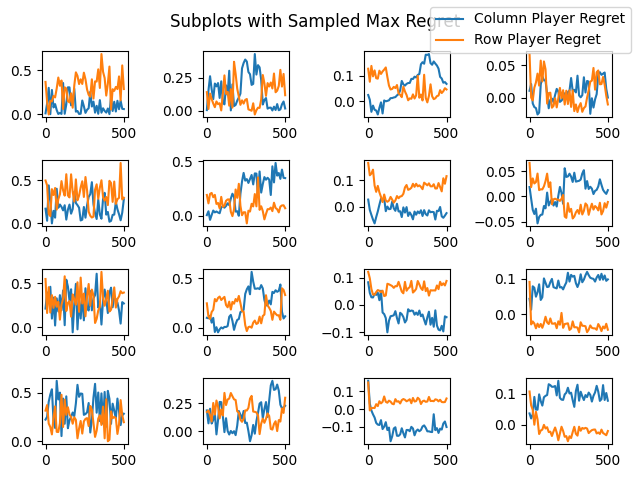

In [ ]:
fig, axes = plt.subplots(4, 4)
fig.suptitle("Subplots with Sampled Max Regret")

checks = 50
for i in range(len(allps)):
    allp = allps[i]
    allq = allqs[i]
    row_devs, col_devs = row_col_devs(allp, allq, checks)
    x = np.linspace(0, len(allp)-1, checks)
    axes[i//4, i%4].plot(x, row_devs, label = "Column Player Regret")
    axes[i//4, i%4].plot(x, col_devs, label = "Row Player Regret")

lines, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
plt.tight_layout()
plt.show()

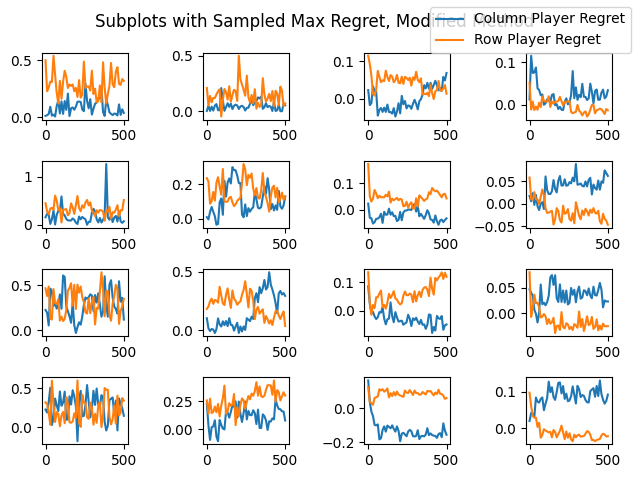

In [ ]:
fig, axes = plt.subplots(4, 4)
fig.suptitle("Subplots with Sampled Max Regret, Modified Method")

checks = 50
for i in range(len(allps)):
    allp = allps[i]
    allq = allqs[i]
    row_devs, col_devs = row_col_devs(allp, allq, checks)
    x = np.linspace(0, len(allp)-1, checks)
    axes[i//4, i%4].plot(x, row_devs, label = "Column Player Regret")
    axes[i//4, i%4].plot(x, col_devs, label = "Row Player Regret")

lines, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
plt.tight_layout()
plt.show()

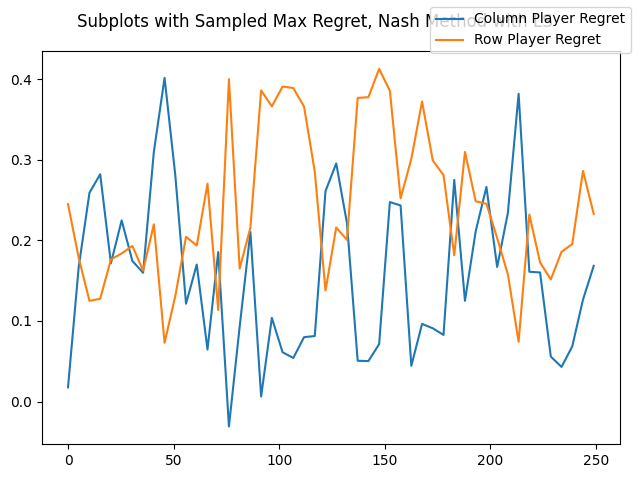

In [37]:
size = 1
fig, axes = plt.subplots()
fig.suptitle("Sampled Max Regret, Nash Method with LS")

checks = 50
row_devs, col_devs = row_col_devs(allp, allq, checks, numpy_type=True)
x = np.linspace(0, len(allp)-1, checks)
axes.plot(x, row_devs, label = "Column Player Regret")
axes.plot(x, col_devs, label = "Row Player Regret")

lines, labels = axes.get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
plt.tight_layout()
plt.show()

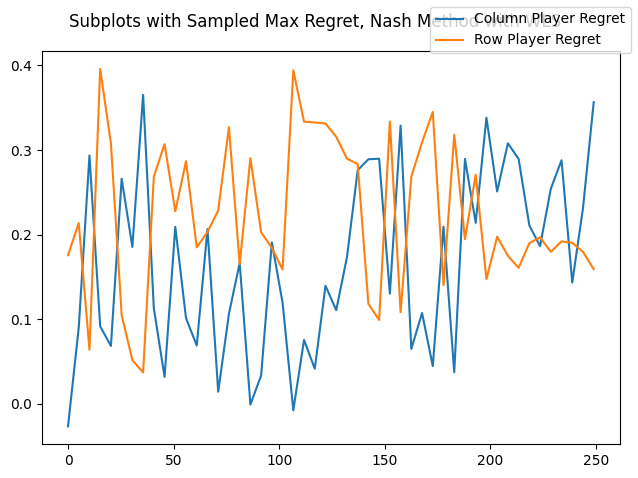

In [38]:
size = 1
fig, axes = plt.subplots()
fig.suptitle("Sampled Max Regret, Nash Method with WLS")

checks = 50
row_devs, col_devs = row_col_devs(allp2, allq2, checks, numpy_type=True)
x = np.linspace(0, len(allp2)-1, checks)
axes.plot(x, row_devs, label = "Column Player Regret")
axes.plot(x, col_devs, label = "Row Player Regret")

lines, labels = axes.get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
plt.tight_layout()
plt.show()

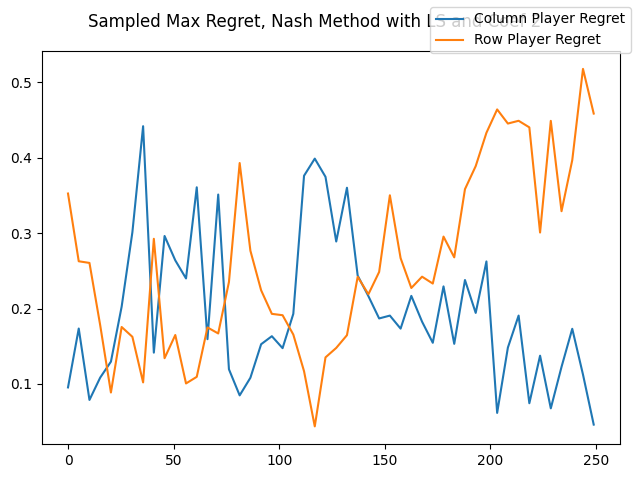

In [28]:
size = 1
fig, axes = plt.subplots()
fig.suptitle("Sampled Max Regret, Nash Method with LS and Coef 2")

checks = 50
row_devs, col_devs = row_col_devs(allp3, allq3, checks, numpy_type=True)
x = np.linspace(0, len(allp3)-1, checks)
axes.plot(x, row_devs, label = "Column Player Regret")
axes.plot(x, col_devs, label = "Row Player Regret")

lines, labels = axes.get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
plt.tight_layout()
plt.show()

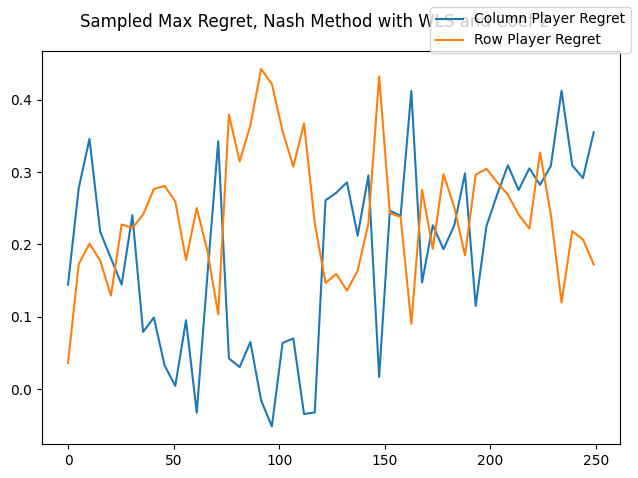

In [30]:
size = 1
fig, axes = plt.subplots()
fig.suptitle("Sampled Max Regret, Nash Method with WLS and Coef 2")

checks = 50
row_devs, col_devs = row_col_devs(allp4, allq4, checks, numpy_type=True)
x = np.linspace(0, len(allp4)-1, checks)
axes.plot(x, row_devs, label = "Column Player Regret")
axes.plot(x, col_devs, label = "Row Player Regret")

lines, labels = axes.get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
plt.tight_layout()
plt.show()

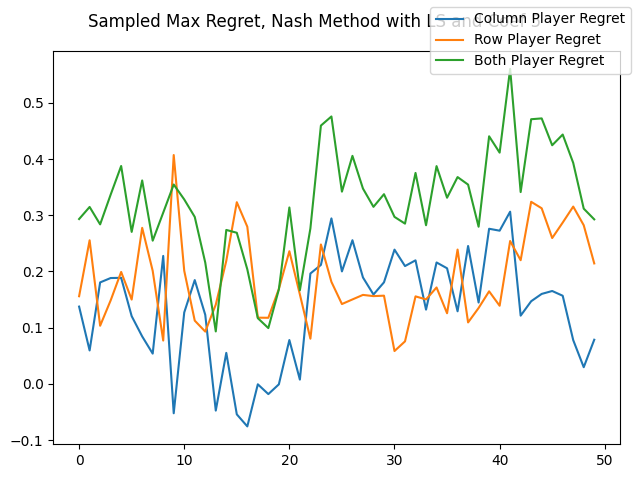

In [38]:
size = 1
fig, axes = plt.subplots()
fig.suptitle("Sampled Max Regret, Nash Method with LS and Coef 5")

checks = 50
row_devs, col_devs = row_col_devs(allp5, allq5, checks, numpy_type=True)
x = np.linspace(0, len(allp5)-1, checks)
axes.plot(x, row_devs, label = "Column Player Regret")
axes.plot(x, col_devs, label = "Row Player Regret")
axes.plot(x, np.array(row_devs) + np.array(col_devs), label = "Both Player Regret")

lines, labels = axes.get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
plt.tight_layout()
plt.show()

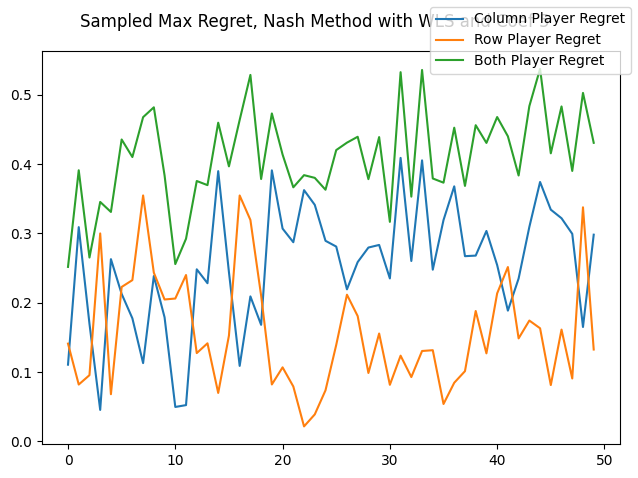

In [39]:
size = 1
fig, axes = plt.subplots()
fig.suptitle("Sampled Max Regret, Nash Method with WLS and Coef 5")

checks = 50
row_devs, col_devs = row_col_devs(allp6, allq6, checks, numpy_type=True)
x = np.linspace(0, len(allp6)-1, checks)
axes.plot(x, row_devs, label = "Column Player Regret")
axes.plot(x, col_devs, label = "Row Player Regret")
axes.plot(x, np.array(row_devs) + np.array(col_devs), label = "Both Player Regret")

lines, labels = axes.get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
plt.tight_layout()
plt.show()